In [58]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [4]:
# !mkdir /kaggle/working/dogs-vs-cats
# !unzip /kaggle/input/dogs-vs-cats/train.zip -d /kaggle/working/dogs-vs-cats
# !unzip /kaggle/input/dogs-vs-cats/test1.zip -d /kaggle/working/dogs-vs-cats

In [64]:
# !nvidia-smi


In [65]:
import os
import csv
import random
import shutil
import subprocess
from PIL import Image
from glob import glob
from tqdm import tqdm
from datetime import datetime

# Data processing
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold

# Image processing
import cv2
import scipy.misc
from scipy.ndimage import rotate

# Graph
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras import Model
from keras import optimizers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten, Dropout
from keras.layers.core import Dense
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.optimizers import Adagrad
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Dense , BatchNormalization , Dropout,Flatten , Activation

# EfficientNet
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam , Adamax


from IPython.display import display
import ipywidgets as widgets


In [8]:

# Define the source directory and destination directory
source_directory = "dogs-vs-cats/train"
destination_directory = "dogs-vs-cats/training_dataset"

# Create destination folders if they don't exist
if not os.path.exists(os.path.join(destination_directory, "cats")):
    os.makedirs(os.path.join(destination_directory, "cats"))
if not os.path.exists(os.path.join(destination_directory, "dogs")):
    os.makedirs(os.path.join(destination_directory, "dogs"))

# Iterate through the files in the source directory
for path in tqdm(glob(os.path.join(source_directory, "*"))):
    # Extract the filename from the path
    filename = os.path.basename(path)
    
    # Determine if it's a cat or dog based on the filename
    if filename.startswith("cat."):
        destination_folder = os.path.join(destination_directory, "cats")
    elif filename.startswith("dog."):
        destination_folder = os.path.join(destination_directory, "dogs")
    else:
        continue  # Skip files that don't match the expected pattern
    
    # Move the file to the corresponding destination folder
    shutil.copy(path, os.path.join(destination_folder, filename))

print("Images have been moved to their corresponding folders.")


100%|██████████| 25000/25000 [00:03<00:00, 8245.00it/s]

Images have been moved to their corresponding folders.


In [9]:
dir_path = '/kaggle/working/dogs-vs-cats/train'

cat_count = 0
dog_count= 0
for i in os.listdir(dir_path):
    if i.startswith('cat.'):
        cat_count += 1
    elif i.startswith('dog.'):
        dog_count += 1
        
print(f"Number of cat images: {cat_count}")
print(f"Number of dog images: {dog_count}")


Number of cat images: 12500
Number of dog images: 12500


In [10]:

# Define the source directory and destination directory
source_directory = "dogs-vs-cats/training_dataset"
destination_directory = "dogs-vs-cats/training"

# Define the percentages for train, validation, and test sets
train_percentage = 0.7  # 70% for training
val_percentage = 0.15  # 15% for validation
test_percentage = 0.15  # 15% for testing

# Create destination folders for train, validation, and test sets
train_dir = os.path.join(destination_directory, "train")
val_dir = os.path.join(destination_directory, "val")
test_dir = os.path.join(destination_directory, "test")

for dir_path in [train_dir, val_dir, test_dir]:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

# Iterate through the classes (cats and dogs)
for class_name in ["cats", "dogs"]:
    class_source_dir = os.path.join(source_directory, class_name)
    class_train_dir = os.path.join(train_dir, class_name)
    class_val_dir = os.path.join(val_dir, class_name)
    class_test_dir = os.path.join(test_dir, class_name)

    # Create destination folders for each class
    for dir_path in [class_train_dir, class_val_dir, class_test_dir]:
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)

    # List all files in the class source directory
    class_files = glob(os.path.join(class_source_dir, "*.jpg"))

    # Shuffle the files randomly
    random.shuffle(class_files)

    # Calculate the split points based on the percentages
    num_files = len(class_files)
    num_train = int(num_files * train_percentage)
    num_val = int(num_files * val_percentage)

    # Split the files into train, validation, and test sets
    train_files = class_files[:num_train]
    val_files = class_files[num_train:num_train + num_val]
    test_files = class_files[num_train + num_val:]

    # Copy the files to their respective destination folders
    for file_path in train_files:
        shutil.copy(file_path, os.path.join(class_train_dir, os.path.basename(file_path)))

    for file_path in val_files:
        shutil.copy(file_path, os.path.join(class_val_dir, os.path.basename(file_path)))

    for file_path in test_files:
        shutil.copy(file_path, os.path.join(class_test_dir, os.path.basename(file_path)))

print("Dataset has been split into train, val, and test sets.")


Dataset has been split into train, val, and test sets.


In [11]:
train_cats_dir = ''
print(f'Total training cat images {len(os.listdir(destination_directory+"/train/cats"))}')
print(f'Total validation cat images {len(os.listdir(destination_directory+"/val/cats"))}')
print(f'Total test cat images {len(os.listdir(destination_directory+"/test/cats"))}')
print('\n')
print(f'Total training dog images {len(os.listdir(destination_directory+"/train/cats"))}')
print(f'Total validation cat images {len(os.listdir(destination_directory+"/val/cats"))}')
print(f'Total test cat images {len(os.listdir(destination_directory+"/test/cats"))}')


Total training cat images 8750
Total validation cat images 1875
Total test cat images 1875


Total training dog images 8750
Total validation cat images 1875
Total test cat images 1875


In [ ]:
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam

# # Define paths
# train_data_dir = "dogs-vs-cats/training/train"
# val_data_dir = "dogs-vs-cats/training/val"

# # Define hyperparameters
# image_size = (224, 224)
# batch_size = 32
# epochs = 10

# # Create data generators for training and validation
# train_datagen = ImageDataGenerator(
#     rescale=1.0/255,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# val_datagen = ImageDataGenerator(rescale=1.0/255)

# train_generator = train_datagen.flow_from_directory(
#     train_data_dir,
#     target_size=image_size,
#     batch_size=batch_size,
#     class_mode='binary', color_mode = 'rgb' , shuffle = True,
# )

# val_generator = val_datagen.flow_from_directory(
#     val_data_dir,
#     target_size=image_size,
#     batch_size=batch_size,
#     class_mode='binary', color_mode = 'rgb' , shuffle = True,
# )

# # Create the EfficientNetB0 base model
# base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Add custom layers on top of the base model
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
# predictions = Dense(1, activation='sigmoid')(x)

# # Create the final model
# model = Model(inputs=base_model.input, outputs=predictions)

# # Freeze the layers of the base model
# for layer in base_model.layers:
#     layer.trainable = False

# # Compile the model
# model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# # Train the model
# history = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // batch_size,
#     epochs=epochs,
#     validation_data=val_generator,
#     validation_steps=val_generator.samples // batch_size
# )

# # Save the trained model
# model.save("dogs-vs-cats/efficientnet_dogs_vs_cats.h5")

# print("Training complete.")


Found 17500 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.
16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/10


2023-09-30 13:39:21.678184: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


546/546 [==============================] - 221s 382ms/step - loss: 0.7047 - accuracy: 0.5053 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 2/10
546/546 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.4935

In [67]:
img_size = (224 , 224)
batch_size = 32
img_shape = (img_size[0] , img_size[1] , 3)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_dir = "dogs-vs-cats/training/train"
valid_dir = "dogs-vs-cats/training/val"
test_dir = "dogs-vs-cats/training/test"

train_gen = tr_gen.flow_from_directory(train_dir , target_size = img_size , class_mode = 'binary' , 
                                       color_mode = 'rgb' , shuffle = True , batch_size = batch_size)

valid_gen = ts_gen.flow_from_directory(valid_dir , target_size = img_size , class_mode = 'binary' , 
                                       color_mode = 'rgb' , shuffle = True , batch_size = batch_size)

test_gen = ts_gen.flow_from_directory(test_dir , target_size = img_size , class_mode = 'binary' , 
                                       color_mode = 'rgb' , shuffle = False , batch_size = batch_size)


Found 17500 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.


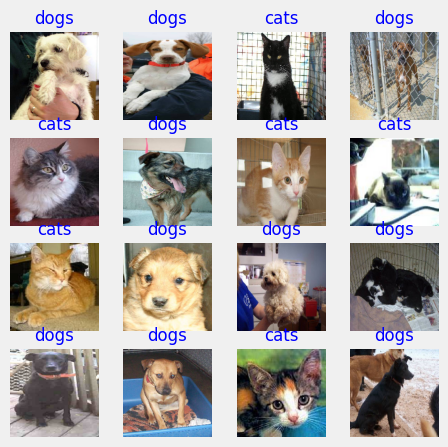

In [68]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)
num_samples = len(images)

plt.figure(figsize=(5, 5))

for i in range(min(16, num_samples)):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    class_index = int(labels[i])
    class_name = classes[class_index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()


In [66]:
img_shape = (img_size[0] , img_size[1] , 3)
base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top= False , weights= 'imagenet' ,
                                                               input_shape= img_shape,pooling= 'max')
base_model.trainable= False

num_classes = len(classes)

model = Sequential([
    base_model,
    BatchNormalization(axis = -1 , momentum = 0.99 , epsilon = 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(l= 0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate = 0.4 , seed = 40),
    Dense(1 , activation= 'sigmoid' )
])
model.compile(Adamax(learning_rate = 0.001) , loss = 'binary_crossentropy' , metrics= ['accuracy'])
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 2048)             28513527  
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 256)               524544    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 29,046,520
Trainable params: 528,897
Non-trainable params: 28,517,623
____________________________________

In [69]:
history = model.fit(x= train_gen , validation_data= valid_gen , epochs= 10 , verbose = 1 , validation_steps = None , shuffle = False)


Epoch 1/10


2023-09-30 15:46:15.176216: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/efficientnetb5/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


547/547 [==============================] - 107s 168ms/step - loss: 2.1716 - accuracy: 0.9794 - val_loss: 0.5183 - val_accuracy: 0.9909
Epoch 2/10
547/547 [==============================] - 88s 161ms/step - loss: 0.3146 - accuracy: 0.9863 - val_loss: 0.1894 - val_accuracy: 0.9896
Epoch 3/10
547/547 [==============================] - 88s 161ms/step - loss: 0.1796 - accuracy: 0.9869 - val_loss: 0.1406 - val_accuracy: 0.9920
Epoch 4/10
547/547 [==============================] - 89s 162ms/step - loss: 0.1496 - accuracy: 0.9880 - val_loss: 0.1266 - val_accuracy: 0.9891
Epoch 5/10
547/547 [==============================] - 89s 162ms/step - loss: 0.1395 - accuracy: 0.9866 - val_loss: 0.1197 - val_accuracy: 0.9880
Epoch 6/10
547/547 [==============================] - 95s 173ms/step - loss: 0.1284 - accuracy: 0.9878 - val_loss: 0.1099 - val_accuracy: 0.9912
Epoch 7/10
547/547 [==============================] - 89s 162ms/step - loss: 0.1235 - accuracy: 0.9874 - val_loss: 0.1073 - val_accuracy: 0.

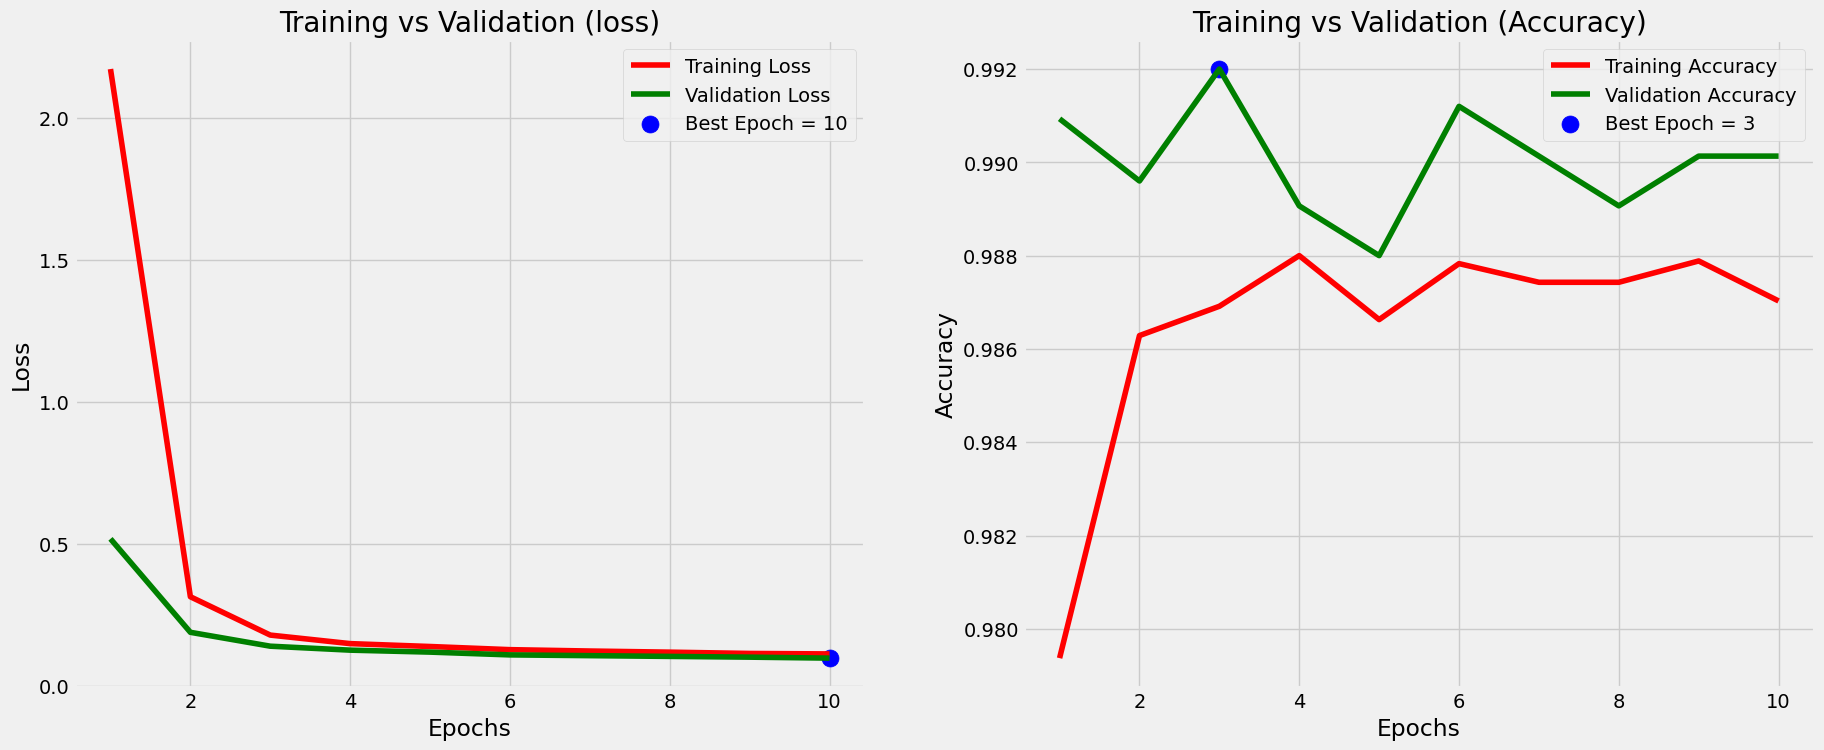

In [70]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)

val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_label = f'Best Epoch = {str(index_acc + 1)}'

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r', label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss +1 , val_lowest , s = 150 , c = 'blue' , label = loss_label)
plt.title('Training vs Validation (loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r', label= 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s= 150 , c = 'blue' , label= acc_label)
plt.title('Training vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show();


In [71]:
train_score = model.evaluate(train_gen , steps= 32 , verbose = 1)
val_score = model.evaluate(valid_gen , steps = 32 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 32 , verbose = 1)

print(f'Train loss = {train_score[0] }')
print(f'Train Accuracy = {train_score[1]}')
print(f'Validation loss = {val_score[0]}')
print(f'Validation Accuracy = {val_score[1]}')
print(f'Test loss = {test_score[0]}')
print(f'Test Accuracy = {test_score[1]}')

32/32 [==============================] - 4s 128ms/step - loss: 0.0960 - accuracy: 0.9873
Train loss = 0.08486329764127731
Train Accuracy = 0.99609375
Validation loss = 0.09569545090198517
Validation Accuracy = 0.990234375
Test loss = 0.09596509486436844
Test Accuracy = 0.9873046875


In [72]:
# Make predictions on the test set
preds = model.predict(test_gen)

# Convert the predictions to binary classes (0 or 1)
predicted_classes = (preds > 0.5).astype(int)

118/118 [==============================] - 18s 122ms/step


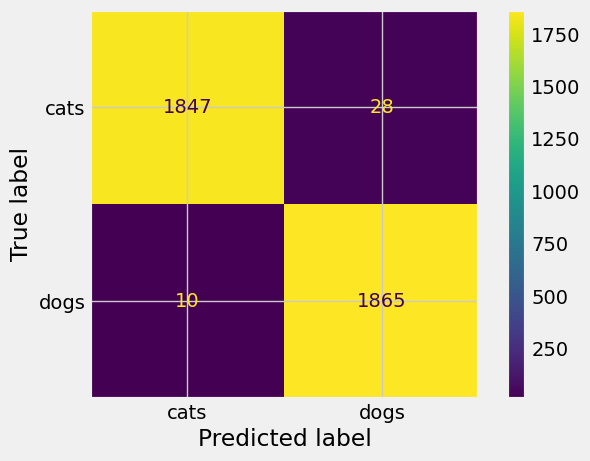

In [73]:
# Get the true labels from the generator
true_classes = test_gen.classes
from sklearn.metrics import confusion_matrix , classification_report, ConfusionMatrixDisplay

# Calculate the confusion matrix
confusion = confusion_matrix(true_classes, predicted_classes)

# Display the confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=test_gen.class_indices)
disp.plot(cmap='viridis', values_format='d')

In [74]:
# Generate and print the classification report
classification_rep = classification_report(true_classes, predicted_classes, target_names=test_gen.class_indices)
print("\nClassification Report:")
print(classification_rep)




Classification Report:
              precision    recall  f1-score   support

        cats       0.99      0.99      0.99      1875
        dogs       0.99      0.99      0.99      1875

    accuracy                           0.99      3750
   macro avg       0.99      0.99      0.99      3750
weighted avg       0.99      0.99      0.99      3750



In [124]:
# 

In [121]:
# model.save('dogs-vs-cats/model')
# tf.keras.models.save_model(model, "dogs-vs-cats/model")
# !rm -rf /kaggle/working/dogs-vs-cats/model
# !ls dogs-vs-cats

In [120]:
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Define the path to the testing dataset
# test_data_dir = "dogs-vs-cats/test1"

# # Define image size, batch size, and the number of classes
# image_size = (224, 224)
# batch_size = 32
# num_classes = 2  # Assuming binary classification (cats and dogs)

# # Create a data generator for the testing dataset
# test_datagen = ImageDataGenerator(rescale=1.0/255)

# test_generator = test_datagen.flow_from_directory(
#     test_data_dir,
#     target_size=image_size,
#     batch_size=batch_size,
#     class_mode='binary'  # Set class_mode to 'binary' for binary classification
# )

# # Load your trained model (replace 'model_path' with the path to your saved model)
# model = tf.keras.models.load_model('/kaggle/working/dogs-vs-cats/model')

# # Evaluate the model on the testing dataset
# test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

# print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Found 0 images belonging to 0 classes.


ValueError: Unable to create a Keras model from SavedModel at /kaggle/working/dogs-vs-cats/model. This SavedModel was exported with `tf.saved_model.save`, and lacks the Keras metadata file. Please save your Keras model by calling `model.save` or `tf.keras.models.save_model`. Note that you can still load this SavedModel with `tf.saved_model.load`.